In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 646.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.4 MB/s eta 0:00:00


# Setup Libraries

In [2]:
import tempfile
import os
import math
import calendar
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Setup Data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
tf_train_dataset = tf.data.Dataset.load("/content/drive/My Drive/ERA5 Data/data/training data 2001")
train_X = tf.stack([ex[0] for ex in tf_train_dataset])
train_y = tf.stack([ex[1] for ex in tf_train_dataset])

In [5]:
print(np.isnan(train_X).sum(), np.isinf(train_X).sum())

0 0


In [6]:
print(np.isnan(train_y).sum(), np.isinf(train_y).sum())

0 0


In [7]:
train_X_np = train_X.numpy()
train_y_np = train_y.numpy()

In [8]:
def plot_histogram(data, x_lab, title):
  fig, ax = plt.subplots(figsize=(8, 6))

  ax.hist(
      data,
      bins=30,
      alpha=0.75,
      edgecolor='black',
      linewidth=1
  )

  ax.set_title(title, fontsize=18, weight='bold')
  ax.set_xlabel(x_lab, fontsize=14)
  ax.set_ylabel('Frequency', fontsize=14)

  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
  fig.tight_layout()

  plt.show()

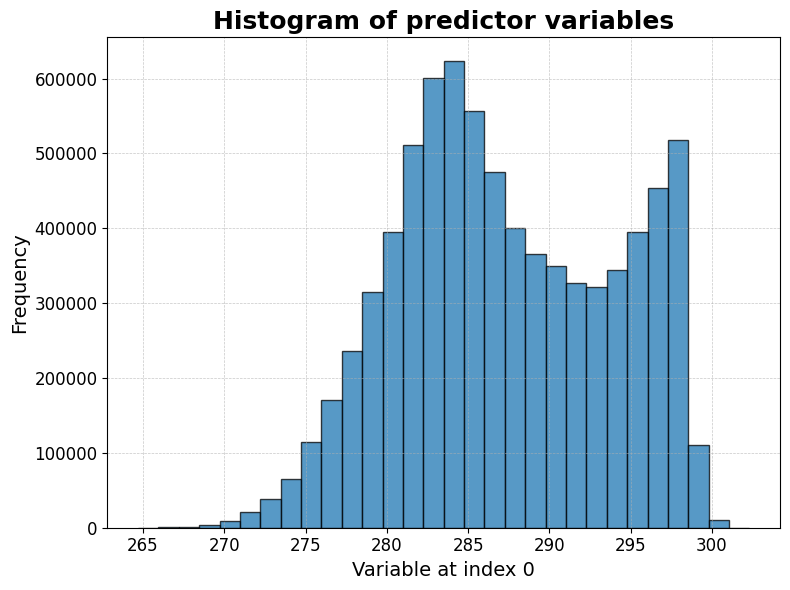

In [9]:
plot_histogram(train_X_np[:, :, :, :, 0].flatten()[train_X_np[:, :, :, :, 0].flatten() > -9999], 'Variable at index 0', 'Histogram of predictor variables')

In [10]:
train_X_masked = np.where(train_X_np <= -9999, np.nan, train_X_np)

In [11]:
X_channel_mean = np.array(
    [np.nanmean(train_X_masked[:, :, :, :, i]) for i in range(train_X_masked.shape[-1])]
)
X_channel_mean

array([ 2.8733960e+02,  2.8518356e+02,  2.8307764e+02,  2.9672681e+02,
        2.9322870e+02,  2.8995871e+02, -2.9985502e-03,  3.0074576e+02,
        2.9458899e+02,  2.9055096e+02,  1.1480216e+01,  5.5924713e+02,
        1.9000979e-03], dtype=float32)

In [12]:
X_channel_std  = np.array(
    [np.nanstd(train_X_masked[:, :, :, :, i]) for i in range(train_X_masked.shape[-1])]
)
X_channel_std

array([6.6319203e+00, 7.3300543e+00, 8.0623484e+00, 7.6074805e+00,
       6.6845088e+00, 6.9685178e+00, 2.5828748e-03, 1.1450218e+01,
       7.2708955e+00, 7.3463850e+00, 7.6361074e+00, 3.2773511e+02,
       5.8767572e-03], dtype=float32)

In [13]:
normalized_train_X_np = (train_X_np - X_channel_mean) / (X_channel_std)
normalized_train_X_np = np.where(train_X_np <= -9999, -9999.0, normalized_train_X_np)
normalized_train_X = tf.convert_to_tensor(normalized_train_X_np, dtype=tf.float32)

print("Normalized train_X shape:", normalized_train_X.shape)
del train_X_np
del train_X_masked
del normalized_train_X_np

Normalized train_X shape: (693, 31, 20, 20, 13)


In [14]:
normalized_train_X = tf.where(tf.less_equal(normalized_train_X, -9999.0), tf.zeros_like(normalized_train_X), normalized_train_X)

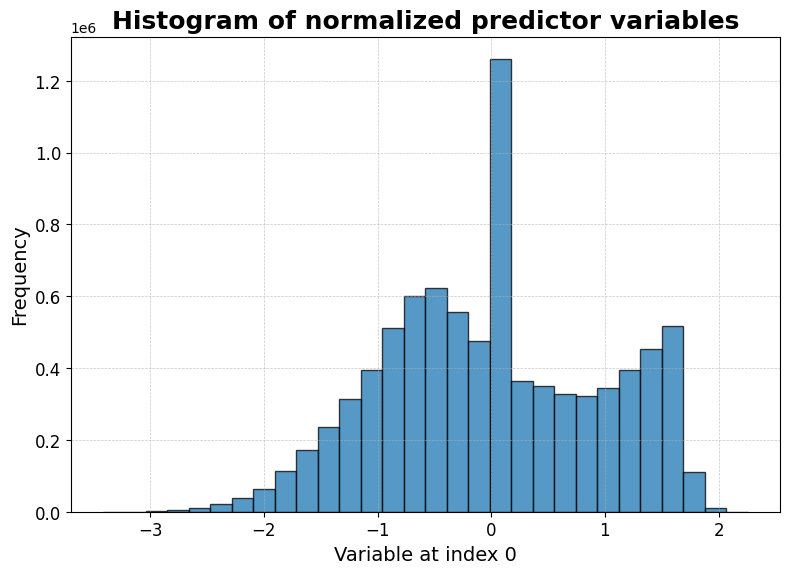

In [15]:
plot_histogram(normalized_train_X[:, :, :, :, 0].numpy().flatten(), 'Variable at index 0', 'Histogram of normalized predictor variables')

In [16]:
train_y_masked = np.where(train_y_np <= -9999, np.nan, train_y_np)

In [17]:
y_channel_mean = np.array(
    [np.nanmean(train_y_masked[:, :, :, :, i]) for i in range(train_y_masked.shape[-1])]
)
y_channel_mean

array([ 2.8711862e+02,  2.8495432e+02,  2.8283240e+02,  2.9651178e+02,
        2.9302600e+02,  2.8976099e+02, -3.0101666e-03,  3.0053397e+02,
        2.9439218e+02,  2.9035413e+02,  1.1412920e+01,  5.4634149e+02,
        1.8306720e-03], dtype=float32)

In [18]:
y_channel_std  = np.array(
    [np.nanstd(train_y_masked[:, :, :, :, i]) for i in range(train_y_masked.shape[-1])]
)
y_channel_std

array([6.6079073e+00, 7.2956376e+00, 8.0311441e+00, 7.5513930e+00,
       6.6332421e+00, 6.9366012e+00, 2.5890006e-03, 1.1331114e+01,
       7.1832690e+00, 7.3218594e+00, 7.6165795e+00, 3.1798929e+02,
       5.6654122e-03], dtype=float32)

In [19]:
normalized_train_y_np = (train_y_np - y_channel_mean) / (y_channel_std)
normalized_train_y_np = np.where(train_y_np <= -9999, -9999.0, normalized_train_y_np)
normalized_train_y = tf.convert_to_tensor(normalized_train_y_np, dtype=tf.float32)

print("Normalized train_y shape:", normalized_train_y.shape)
del train_y_np
del train_y_masked
del normalized_train_y_np

Normalized train_y shape: (693, 31, 20, 20, 13)


# Setup Transformer Architecture

In [20]:
class DecomposeLayer(tf.keras.layers.Layer):
    def __init__(self, cuboid_size, **kwargs):
        """
        cuboid_size: Tuple (bT, bH, bW) defining the size of each cuboid.
        """
        super(DecomposeLayer, self).__init__(**kwargs)
        self.cuboid_size = cuboid_size   # (bT, bH, bW)

    def call(self, inputs):
        # inputs should be of shape [B, T, H, W, C]
        input_shape = tf.shape(inputs)
        B, T, H, W, C = input_shape[0], input_shape[1], input_shape[2], input_shape[3], input_shape[4]
        bT, bH, bW = self.cuboid_size

        # (1) Ensure that T, H, W are divisible by bT, bH, bW.
        pad_T = (bT - T % bT) % bT
        pad_H = (bH - H % bH) % bH
        pad_W = (bW - W % bW) % bW

        condition = tf.logical_or(
              tf.logical_or(tf.greater(pad_T, 0), tf.greater(pad_H, 0)),
              tf.greater(pad_W, 0)
            )

        def pad_fn():
            return tf.pad(inputs,
                          paddings=[[0, 0],
                                    [0, pad_T],
                                    [0, pad_H],
                                    [0, pad_W],
                                    [0, 0]])

        def identity_fn():
            return inputs

        inputs = tf.cond(condition, pad_fn, identity_fn)

        padded_shape = tf.shape(inputs)
        T_new = padded_shape[1]
        H_new = padded_shape[2]
        W_new = padded_shape[3]

        # For contiguous cuboids, similar to window partitioning as in Swin Transformer.
        # Reshape to group each (bT, bH, bW) block together.
        x = tf.reshape(inputs, [B,
                                  T_new // bT, bT,
                                  H_new // bH, bH,
                                  W_new // bW, bW,
                                  C])

        # Transpose to bring the cuboid grid dimensions together:
        # New shape: [B, T//bT, H//bH, W//bW, bT, bH, bW, C]
        x = tf.transpose(x, [0, 1, 3, 5, 2, 4, 6, 7])

        # Merge the cuboid grid dimensions into one axis.
        num_cuboids = (T_new // bT) * (H_new // bH) * (W_new // bW)
        cuboids = tf.reshape(x, [B, num_cuboids, bT, bH, bW, C])

        # Output shape: [B, , sequence_length, bT, bH, bW, C]
        return cuboids

    def build(self, input_shape):
        # input_shape: (B, T, H, W, C)
        super(DecomposeLayer, self).build(input_shape)


    def compute_output_shape(self, input_shape):
        # Assuming input_shape is (B, T, H, W, C)
        bT, bH, bW = self.cuboid_size
        B, T, H, W, C = input_shape
        num_cuboids = (T // bT) * (H // bH) * (W // bW)
        return (B, num_cuboids, bT, bH, bW, C)

In [21]:
class MergeLayer(tf.keras.layers.Layer):
    def __init__(self, original_shape, cuboid_size, **kwargs):
        """
        original_shape: Tuple (T, H, W) representing the spatiotemporal dimensions
                        T must be divisible by bT, H by bH, and W by bW.
        cuboid_size: Tuple (bT, bH, bW) defining the size of each cuboid.
        """

        super(MergeLayer, self).__init__(**kwargs)
        self.original_shape = original_shape     # (T, H, W)
        self.cuboid_size = cuboid_size           # (bT, bH, bW)

    def call(self, inputs):
        """
        inputs: Tensor of shape [B, num_cuboids, bT*bH*bW, C].
        Returns:
            Merged tensor of shape [B, T, H, W, C].
        """

        # Unpack original spatiotemporal dimensions and cuboid dimensions.
        T, H, W = self.original_shape
        bT, bH, bW = self.cuboid_size

        # Compute the grid dimensions (number of cuboids in each dimension).
        grid_T = T // bT
        grid_H = H // bH
        grid_W = W // bW

        B = tf.shape(inputs)[0]
        # The input shape is expected to be [B, sequence_length, bT, bH, bW, C].
        # Reshape the cuboid sequence tokens back to their structured shape.
        x = tf.reshape(inputs, [B, grid_T, grid_H, grid_W, bT, bH, bW, -1])

        # Invert the transpose in the decompose layer
        x = tf.transpose(x, perm=[0, 1, 4, 2, 5, 3, 6, 7])

        # Reshape back to the merged spatiotemporal shape: [B, T, H, W, C].
        merged = tf.reshape(x, [B, T, H, W, -1])

        return merged

    def build(self, input_shape):
        # input_shape: (B, num_cuboids, bT, bH, bW, C)
        super(MergeLayer, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        # The output shape is [B, T, H, W, C] where T,H,W come from self.original_shape.
        return (input_shape[0], self.original_shape[0], self.original_shape[1], self.original_shape[2], input_shape[-1])

In [22]:
class CuboidSelfAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,
                 dim,
                 num_heads,
                 original_shape, # tuple (T, H, W)
                 cuboid_size, # tuple (bT, bH, bW)
                 attn_dropout_rate=0.45,
                 proj_dropout_rate=0.45,
                 qkv_bias=True,
                 **kwargs):
        """
        Parameters:
          - dim: The input channel dimension (C).
          - num_heads: Number of attention heads.
          - cuboid_size: Tuple (bT, bH, bW) defining the size of each cuboid.
          - attn_dropout_rate: Dropout rate for attention weights.
          - proj_dropout_rate: Dropout rate after the final projection.
          - global_dim_ratio: Scaling factor for the global branch channel dimension.
          - qkv_bias: Boolean to include bias in the linear projections.
        """
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.original_shape = original_shape
        self.cuboid_size = cuboid_size  # (bT, bH, bW)
        self.bT, self.bH, self.bW = cuboid_size
        self.cuboid_volume = self.bT * self.bH * self.bW
        self.attn_dropout_rate = attn_dropout_rate
        self.proj_dropout_rate = proj_dropout_rate
        self.global_dim_ratio = 1

        self.decompose = DecomposeLayer(cuboid_size=self.cuboid_size)
        self.merge = MergeLayer(original_shape=self.original_shape, cuboid_size=self.cuboid_size)

        # This projection maps input tokens to concatenated Q, K, V of dimension 3*dim.
        self.qkv = tf.keras.layers.Dense(dim * 3, use_bias=qkv_bias)

        # -------------------------
        # Relative Positional Bias
        # -------------------------
        table_size = (2 * self.bT - 1) * (2 * self.bH - 1) * (2 * self.bW - 1)
        self.relative_position_bias_table = self.add_weight(
            name="relative_position_bias_table",
            shape=[table_size, num_heads],
            initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True)
        # Compute relative position index for a cuboid of size (bT, bH, bW)
        coords_t = tf.range(self.bT)    # (bT,)
        coords_h = tf.range(self.bH)    # (bH,)
        coords_w = tf.range(self.bW)    # (bW,)
        coords = tf.stack(tf.meshgrid(coords_t, coords_h, coords_w, indexing='ij'))  # (3, bT, bH, bW)
        coords_flat = tf.reshape(coords, (3, -1))  # (3, cuboid_volume)
        # Calculate pairwise differences → (cuboid_volume, cuboid_volume, 3)
        relative_coords = tf.expand_dims(coords_flat, axis=2) - tf.expand_dims(coords_flat, axis=1)
        # Shift so that minimum is 0.
        shift = tf.constant([self.bT - 1, self.bH - 1, self.bW - 1], dtype=tf.int32)
        shift = tf.reshape(shift, (3, 1, 1))
        relative_coords += shift
        multiplier = tf.constant([(2 * self.bH - 1) * (2 * self.bW - 1), (2 * self.bW - 1), 1], dtype=tf.int32)
        multiplier = tf.reshape(multiplier, (3, 1, 1))  # Reshape for correct broadcasting
        relative_coords = relative_coords * multiplier
        self.relative_position_index = tf.reduce_sum(relative_coords, axis=0)  # (cuboid_volume, cuboid_volume)

        # -------------------------
        # Dropout and Final Projection Layers for Local Branch
        # -------------------------
        self.attn_dropout = tf.keras.layers.Dropout(self.attn_dropout_rate)
        self.proj = tf.keras.layers.Dense(dim)
        self.proj_dropout = tf.keras.layers.Dropout(self.proj_dropout_rate)

        # -------------------------
        # Global Branch Projections
        # -------------------------
        # Local-to-global branch: project local tokens to queries.
        self.l2g_q_dense = tf.keras.layers.Dense(dim, use_bias=qkv_bias)
        # Project global vectors to keys and values.
        self.l2g_global_kv_dense = tf.keras.layers.Dense(dim * 2, use_bias=qkv_bias)
        # Global-to-local branch (if needed).
        self.g2l_global_q_dense = tf.keras.layers.Dense(dim, use_bias=qkv_bias)
        self.g2l_k_dense = tf.keras.layers.Dense(dim, use_bias=qkv_bias)
        self.g2l_v_dense = tf.keras.layers.Dense(dim, use_bias=qkv_bias)
        # Global self-attention among global vectors.
        self.g2g_global_qkv_dense = tf.keras.layers.Dense((self.global_dim_ratio * dim) * 3, use_bias=qkv_bias)

        # -------------------------
        # Fusion Projection
        # -------------------------
        # Fusion layer that takes concatenated features from local and global branches (2*dim) and projects back to dim.
        self.fusion_dense = tf.keras.layers.Dense(dim, use_bias=True)

    def call(self, x, global_vectors, mask=None, training=False):
        """
        Input:
          - x: Input tensor of shape (B, T, H, W, C).
          - global_vectors: tensor of shape (B, num_global, global_dim_ratio * dim).
          - mask: Optional attention mask of shape (B, num_heads, num_cuboids, cuboid_volume, cuboid_volume).
          - training: Boolean.
        Processing:
          - Decompose input into cuboids.
          - Apply QKV projection and reshape to obtain (B, num_heads, num_cuboids, cuboid_volume, head_dim).
          - Compute relative positional bias and add it to attention scores.
          - Apply masking and dropout.
          - Compute weighted-sum for local self-attention.
          - Process global branch using separate projections and apply global self-attention to global vectors.
          - Fuse local and global outputs via concatenation and a final fusion projection.
          - Merge cuboids back to original spatial layout.
        Output:
          - Tensor of shape (B, T, H, W, C).
          - Updated global vectors.
        """
        B = tf.shape(x)[0]  # Batch size

        # -------------------------
        # Decomposition
        # -------------------------
        decomposed = self.decompose(x)  # shape: (B, num_cuboids, bT, bH, bW, C)
        B, num_cuboids, bT, bH, bW, C = tf.unstack(tf.shape(decomposed))
        local_tokens = tf.reshape(decomposed, (B, num_cuboids, self.cuboid_volume, C)) # shape: (B, num_cuboids, cuboid_volume, C)

        # -------------------------
        # Local Attention
        # -------------------------
        # Compute concatenated Q, K, V.
        qkv = self.qkv(local_tokens) # shape: (B, num_cuboids, cuboid_volume, 3*dim)
        qkv = tf.reshape(qkv, (B, num_cuboids, self.cuboid_volume, 3, self.num_heads, self.head_dim))
        qkv = tf.transpose(qkv, perm=[3, 0, 4, 1, 2, 5]) # shape: (3, B, num_heads, num_cuboids, cuboid_volume, head_dim)
        q_local, k_local, v_local = qkv[0], qkv[1], qkv[2] # shape: (B, num_heads, num_cuboids, cuboid_volume, head_dim)
        q_local = q_local * self.scale # Scale queries.
        attn_local = tf.matmul(q_local, k_local, transpose_b=True) # shape: (B, num_heads, num_cuboids, cuboid_volume, cuboid_volume)

        rp_index = tf.reshape(self.relative_position_index, [-1]) # shape: (cuboid_volume*cuboid_volume,)
        rp_bias = tf.gather(self.relative_position_bias_table, rp_index) # shape: (cuboid_volume*cuboid_volume, num_heads)
        rp_bias = tf.reshape(rp_bias, (self.cuboid_volume, self.cuboid_volume, self.num_heads)) # shape: (cuboid_volume, cuboid_volume, num_heads)
        rp_bias = tf.transpose(rp_bias, perm=[2, 0, 1]) # shape: (num_heads, cuboid_volume, cuboid_volume)
        rp_bias = tf.expand_dims(rp_bias, axis=0)
        rp_bias = tf.expand_dims(rp_bias, axis=2) # shape: (B, num_heads, num_cuboids, cuboid_volume, cuboid_volume)
        attn_local = attn_local + rp_bias

        if mask is not None:
            # Assume mask is of shape (B, num_heads, num_cuboids, cuboid_volume, cuboid_volume)
            attn_local += (1.0 - mask) * (-1e9)
        attn_local = tf.nn.softmax(attn_local, axis=-1)
        attn_local = self.attn_dropout(attn_local, training=training)

        local_out = tf.matmul(attn_local, v_local) # shape: (B, num_heads, num_cuboids, cuboid_volume, head_dim)
        local_out = tf.transpose(local_out, perm=[0, 2, 3, 1, 4]) # shape: (B, num_cuboids, cuboid_volume, num_heads, head_dim)
        local_out = tf.reshape(local_out, (B, num_cuboids, self.cuboid_volume, self.dim)) # shape: (B, num_cuboids, cuboid_volume, dim)

        # -------------------------
        # Global Attention
        # -------------------------
        # Local-to-Global Attention
        l2g_q = self.l2g_q_dense(local_tokens)  # (B, num_cuboids, cuboid_volume, C)
        l2g_q = tf.reshape(l2g_q, (B, num_cuboids, self.cuboid_volume, self.num_heads, self.head_dim))
        l2g_q = tf.transpose(l2g_q, perm=[0, 3, 1, 2, 4]) # shape: (B, num_heads, num_cuboids, cuboid_volume, head_dim)
        l2g_q = l2g_q * self.scale

        l2g_global_kv = self.l2g_global_kv_dense(global_vectors)
        l2g_global_k, l2g_global_v = tf.split(l2g_global_kv, num_or_size_splits=2, axis=-1)
        l2g_global_k = tf.reshape(l2g_global_k, (B, -1, self.num_heads, self.head_dim)) # shape: (B, num_global, num_heads, head_dim)
        l2g_global_k = tf.transpose(l2g_global_k, perm=[0, 2, 1, 3]) # shape: (B, num_heads, num_global, head_dim)
        l2g_global_k = tf.expand_dims(l2g_global_k, axis=2)
        l2g_global_v = tf.reshape(l2g_global_v, (B, -1, self.num_heads, self.head_dim))
        l2g_global_v = tf.transpose(l2g_global_v, perm=[0, 2, 1, 3])

        attn_l2g = tf.matmul(l2g_q, l2g_global_k, transpose_b=True) # shape: (B, num_heads, num_cuboids, cuboid_volume, num_global)
        attn_combined = tf.concat([attn_local, attn_l2g], axis=-1) # shape: (B, num_heads, num_cuboids, cuboid_volume, cuboid_volume + num_global)
        l2g_global_v_expanded = tf.expand_dims(l2g_global_v, axis=2)
        num_cuboids = tf.shape(v_local)[2]
        l2g_global_v_tiled = tf.tile(l2g_global_v_expanded, [1, 1, num_cuboids, 1, 1])
        v_combined = tf.concat([v_local, l2g_global_v_tiled], axis=3) # shape: (B, num_heads, num_cuboids, cuboid_volume + num_global, head_dim)
        attn_combined = tf.nn.softmax(attn_combined, axis=-1)
        attn_combined = self.attn_dropout(attn_combined, training=training)

        global_out = tf.matmul(attn_combined, v_combined) # shape: (B, num_heads, num_cuboids, cuboid_volume, head_dim)
        global_out = tf.transpose(global_out, perm=[0, 2, 3, 1, 4]) # shape: first transpose to (B, num_cuboids, cuboid_volume, num_heads, head_dim)
        global_out = tf.reshape(global_out, (B, num_cuboids, self.cuboid_volume, self.dim)) # shape: (B, num_cuboids, cuboid_volume, dim)

        # Global Self-Attention
        g2g_qkv = self.g2g_global_qkv_dense(global_vectors)  # shape: (B, num_global, 3*global_dim_ratio*dim)
        g2g_qkv = tf.reshape(g2g_qkv, (B, -1, 3, self.num_heads, self.head_dim))
        g2g_qkv = tf.transpose(g2g_qkv, perm=[2, 0, 3, 1, 4]) # shape: (3, B, num_heads, num_global, head_dim)
        q_global, k_global, v_global = g2g_qkv[0], g2g_qkv[1], g2g_qkv[2] # shape: (B, num_heads, num_global, head_dim)
        q_global = q_global * self.scale
        attn_global = tf.matmul(q_global, k_global, transpose_b=True)
        attn_global = tf.nn.softmax(attn_global, axis=-1)
        attn_global = self.attn_dropout(attn_global, training=training)
        updated_global = tf.matmul(attn_global, v_global)  # (B, num_heads, num_global, head_dim)
        updated_global = tf.transpose(updated_global, perm=[0, 2, 1, 3]) # (B, num_global, num_heads, head_dim)
        updated_global = tf.reshape(updated_global, (B, -1, self.global_dim_ratio * self.dim))

        # -------------------------
        # Fusion of Local and Global
        # -------------------------
        fused = tf.concat([local_out, global_out], axis=-1)  # shape: (B, num_cuboids, cuboid_volume, 2*dim)
        fused = self.fusion_dense(fused)  # shape: (B, num_cuboids, cuboid_volume, dim)
        final_out_local = fused
        final_out_local = self.proj(final_out_local)  #  shape: (B, num_cuboids, cuboid_volume, dim)
        final_out_local = self.proj_dropout(final_out_local, training=training)

        # -------------------------
        # Merge Cuboids
        # -------------------------
        final_out_cuboids = tf.reshape(final_out_local, (B, num_cuboids, self.bT, self.bH, self.bW, self.dim))
        final_out = self.merge(final_out_cuboids) # shape: (B, T, H, W, C)

        return final_out, updated_global

    def build(self, input_shape):
        """
        Build the layer.
        """
        super().build(input_shape)

    def compute_output_shape(self, input_shape):
        """
        Returns the output shape(s) of the layer.
          - For input of shape (B, T, H, W, C), the output is (B, T, H, W, C)
          - The updated global vectors remain (B, num_global, global_dim_ratio * dim)
        """
        batch_size = input_shape[0]
        T, H, W = self.original_shape
        output_x_shape = (batch_size, T, H, W, self.dim)

        output_global_shape = (global_shape[0],
                               global_shape[1],
                               self.global_dim_ratio * self.dim)
        return [output_x_shape, output_global_shape]

In [23]:
class CuboidCrossAttentionLayer(tf.keras.layers.Layer):
    def __init__(self,
                 dim,
                 num_heads,
                 original_shape,       # tuple (T, H, W)
                 cuboid_size,          # tuple (bT, bH, bW)
                 attn_dropout_rate=0.45,
                 proj_dropout_rate=0.45,
                 qkv_bias=True,
                 **kwargs):
        """
        CuboidCrossAttentionLayer implements cross attention on decomposed cuboids.

        Parameters:
          - dim: Input channel dimension.
          - num_heads: Number of attention heads.
          - original_shape: The full spatial–temporal shape (T, H, W) of the input.
          - cuboid_size: Tuple (bT, bH, bW) defining the cuboid size.
          - attn_dropout_rate: Dropout rate on attention weights.
          - proj_dropout_rate: Dropout rate after the final projection.
          - qkv_bias: Whether to use bias in linear projections.
        """
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.original_shape = original_shape     # (T, H, W)
        self.cuboid_size = cuboid_size           # (bT, bH, bW)
        self.attn_dropout_rate = attn_dropout_rate
        self.proj_dropout_rate = proj_dropout_rate
        self.qkv_bias = qkv_bias

        # Instantiate the helper layers for cuboid decomposition and merging.
        self.decompose = DecomposeLayer(cuboid_size=self.cuboid_size)
        self.merge = MergeLayer(original_shape=self.original_shape, cuboid_size=self.cuboid_size)

        # -------------------------
        # Relative Positional Bias
        # -------------------------
        table_size = (2 * self.cuboid_size[0] - 1) * (2 * self.cuboid_size[1] - 1) * (2 * self.cuboid_size[2] - 1)
        self.relative_position_bias_table = self.add_weight(
            name="relative_position_bias_table",
            shape=[table_size, num_heads],
            initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True
        )
        # Precompute the relative position index for a cuboid.
        coords_t = tf.range(self.cuboid_size[0])  # (bT,)
        coords_h = tf.range(self.cuboid_size[1])  # (bH,)
        coords_w = tf.range(self.cuboid_size[2])  # (bW,)
        coords = tf.stack(tf.meshgrid(coords_t, coords_h, coords_w, indexing='ij'))  # (3, bT, bH, bW)
        coords_flat = tf.reshape(coords, (3, -1))  # (3, cuboid_volume)
        relative_coords = tf.expand_dims(coords_flat, axis=2) - tf.expand_dims(coords_flat, axis=1)
        offset = tf.constant([self.cuboid_size[0]-1, self.cuboid_size[1]-1, self.cuboid_size[2]-1], dtype=tf.int32)
        offset = tf.reshape(offset, (3,1,1))
        relative_coords += offset
        multiplier = tf.constant([(2*self.cuboid_size[1]-1) * (2*self.cuboid_size[2]-1),
                                  (2*self.cuboid_size[2]-1),
                                  1], dtype=tf.int32)
        relative_coords = relative_coords * tf.reshape(multiplier, (3,1,1))
        self.relative_position_index = tf.reduce_sum(relative_coords, axis=0)  # (cuboid_volume, cuboid_volume)

        # -------------------------
        # Local Branch
        # -------------------------
        self.q_proj = tf.keras.layers.Dense(dim, use_bias=self.qkv_bias, name="q_proj")
        self.kv_proj = tf.keras.layers.Dense(dim * 2, use_bias=self.qkv_bias, name="kv_proj")

        # Dropout layers and final projection for local branch.
        self.attn_dropout = tf.keras.layers.Dropout(self.attn_dropout_rate)
        self.proj = tf.keras.layers.Dense(dim, name="final_proj")
        self.proj_dropout = tf.keras.layers.Dropout(self.proj_dropout_rate)

        # -------------------------
        # Global Branch Projections
        # -------------------------
        # For local-to-global branch, project the query tokens
        self.l2g_q_dense = tf.keras.layers.Dense(dim, use_bias=self.qkv_bias, name="l2g_q_dense")
        # Project global vectors (passed in) to keys and values.
        self.l2g_global_kv_dense = tf.keras.layers.Dense(dim * 2, use_bias=self.qkv_bias, name="l2g_global_kv_dense")
        # Global-to-local branch: additional projection on query for combining with memory later.
        self.g2l_q_dense = tf.keras.layers.Dense(dim, use_bias=self.qkv_bias, name="g2l_q_dense")
        self.g2l_k_dense = tf.keras.layers.Dense(dim, use_bias=self.qkv_bias, name="g2l_k_dense")
        self.g2l_v_dense = tf.keras.layers.Dense(dim, use_bias=self.qkv_bias, name="g2l_v_dense")

        self.g2g_global_qkv_dense = tf.keras.layers.Dense(dim * 3,
                                                          use_bias=self.qkv_bias,
                                                          name="g2g_global_qkv_dense")

    def call(self, x, memory, global_vectors, mask=None, training=False):
        """
        x: Query tensor of shape (B, T, H, W, C) (e.g., from the decoder).
        memory: Memory tensor of shape (B, T_mem, H, W, C) (e.g., from the encoder).
        global_vectors: Global tokens tensor of shape (B, num_global, dim).
        mask: Optional attention mask with shape (B, num_heads, num_cuboids, cuboid_volume, cuboid_volume_memory)
        training: Boolean.

        Returns:
          final_out: Output tensor of shape (B, T, H, W, dim), after merging cuboid outputs.
          updated_global: Updated global vector, shape (B, num_global, dim)
        """
        B = tf.shape(x)[0]

        decomposed_x = self.decompose(x)  # Shape: (B, num_cuboids, bT, bH, bW, C)
        B, num_cuboids, bT, bH, bW, C = tf.unstack(tf.shape(decomposed_x))
        cuboid_volume = bT * bH * bW
        query_tokens = tf.reshape(decomposed_x, (B, num_cuboids, cuboid_volume, C))

        decomposed_mem = self.decompose(memory)
        B_mem, num_cuboids_mem, mbT, mbH, mbW, C_mem = tf.unstack(tf.shape(decomposed_mem))
        mem_cuboid_volume = mbT * mbH * mbW
        memory_tokens = tf.reshape(decomposed_mem, (B, num_cuboids_mem, mem_cuboid_volume, C_mem))

        q = self.q_proj(query_tokens)  # (B, num_cuboids, cuboid_volume, dim)
        kv = self.kv_proj(memory_tokens)  # (B, num_cuboids_mem, mem_cuboid_volume, 2*dim)
        k, v = tf.split(kv, num_or_size_splits=2, axis=-1)  # each: (B, num_cuboids, mem_cuboid_volume, dim)
        q = tf.reshape(q, (B, num_cuboids, cuboid_volume, self.num_heads, self.head_dim))
        q = tf.transpose(q, perm=[0, 3, 1, 2, 4])  # (B, num_heads, num_cuboids, cuboid_volume, head_dim)
        k = tf.reshape(k, (B, num_cuboids_mem, mem_cuboid_volume, self.num_heads, self.head_dim))
        k = tf.transpose(k, perm=[0, 3, 1, 2, 4])  # (B, num_heads, num_cuboids, mem_cuboid_volume, head_dim)
        v = tf.reshape(v, (B, num_cuboids_mem, mem_cuboid_volume, self.num_heads, self.head_dim))
        v = tf.transpose(v, perm=[0, 3, 1, 2, 4])  # (B, num_heads, num_cuboids, mem_cuboid_volume, head_dim)
        q = q * self.scale
        attn_scores = tf.matmul(q, k, transpose_b=True)  # (B, num_heads, num_cuboids, cuboid_volume, mem_cuboid_volume)

        rp_index = tf.reshape(self.relative_position_index, [-1])
        rp_bias = tf.gather(self.relative_position_bias_table, rp_index)
        rp_bias = tf.reshape(rp_bias, (cuboid_volume, cuboid_volume, self.num_heads))
        rp_bias = tf.transpose(rp_bias, perm=[2, 0, 1])  # (num_heads, cuboid_volume, cuboid_volume)
        rp_bias = tf.expand_dims(rp_bias, axis=0)  # (1, num_heads, cuboid_volume, cuboid_volume)
        rp_bias = tf.expand_dims(rp_bias, axis=2)  # (1, num_heads, 1, cuboid_volume, cuboid_volume)
        attn_scores = attn_scores + rp_bias

        if mask is not None:
            attn_scores += (1.0 - mask) * (-1e9)

        attn_scores = tf.nn.softmax(attn_scores, axis=-1)
        attn_scores = self.attn_dropout(attn_scores, training=training)
        local_out = tf.matmul(attn_scores, v)  # (B, num_heads, num_cuboids, cuboid_volume, head_dim)
        local_out = tf.transpose(local_out, perm=[0, 2, 3, 1, 4])  # (B, num_cuboids, cuboid_volume, num_heads, head_dim)
        local_out = tf.reshape(local_out, (B, num_cuboids, cuboid_volume, self.dim))  # merge heads

        l2g_q = self.l2g_q_dense(query_tokens)
        l2g_q = tf.reshape(l2g_q, (B, num_cuboids, cuboid_volume, self.num_heads, self.head_dim))
        l2g_q = tf.transpose(l2g_q, perm=[0, 3, 1, 2, 4])  # (B, num_heads, num_cuboids, cuboid_volume, head_dim)
        l2g_q = l2g_q * self.scale
        l2g_global_kv = self.l2g_global_kv_dense(global_vectors)  # (B, num_global, 2*dim)
        l2g_global_k, l2g_global_v = tf.split(l2g_global_kv, num_or_size_splits=2, axis=-1)
        l2g_global_k = tf.reshape(l2g_global_k, (B, -1, self.num_heads, self.head_dim))
        l2g_global_k = tf.transpose(l2g_global_k, perm=[0, 2, 1, 3])  # (B, num_heads, num_global, head_dim)
        l2g_global_k = tf.expand_dims(l2g_global_k, axis=2)
        l2g_global_v = tf.reshape(l2g_global_v, (B, -1, self.num_heads, self.head_dim))
        l2g_global_v = tf.transpose(l2g_global_v, perm=[0, 2, 1, 3])  # (B, num_heads, num_global, head_dim)
        attn_l2g = tf.matmul(l2g_q, l2g_global_k, transpose_b=True)  # (B, num_heads, num_cuboids, cuboid_volume, num_global)
        attn_combined = tf.concat([attn_scores, attn_l2g], axis=-1)  # new shape: (B, num_heads, num_cuboids, cuboid_volume, mem_length + num_global)

        l2g_global_v_expanded = tf.expand_dims(l2g_global_v, axis=2)  # (B, num_heads, 1, num_global, head_dim)
        l2g_global_v_expanded = tf.tile(l2g_global_v_expanded, [1, 1, num_cuboids, 1, 1])
        v_combined = tf.concat([v, l2g_global_v_expanded], axis=3)
        attn_combined = tf.nn.softmax(attn_combined, axis=-1)
        attn_combined = self.attn_dropout(attn_combined, training=training)
        global_out = tf.matmul(attn_combined, v_combined)  # (B, num_heads, num_cuboids, cuboid_volume, head_dim)
        global_out = tf.transpose(global_out, perm=[0, 2, 3, 1, 4])
        global_out = tf.reshape(global_out, (B, num_cuboids, cuboid_volume, self.dim))

        fused = tf.concat([local_out, global_out], axis=-1)  # (B, num_cuboids, cuboid_volume, 2*dim)
        fused = self.proj(fused)  # (B, num_cuboids, cuboid_volume, dim)
        fused = self.proj_dropout(fused, training=training)

        final_out = tf.reshape(fused, (B, num_cuboids, bT, bH, bW, self.dim))
        final_out = self.merge(final_out)  # (B, T, H, W, dim)

        updated_global = global_vectors
        return final_out, updated_global

    def compute_output_shape(self, input_shape):
        # For cross-attention, assume inputs (x, memory, global_vectors)
        # x has shape (B, T, H, W, C) so output shape will be (B, T, H, W, dim)
        # Global vector output remains (B, num_global, dim)
        if isinstance(input_shape, (list, tuple)):
            B = input_shape[0][0]
        else:
            B = input_shape[0]
        return ((B, ) + self.original_shape + (self.dim, ), (B, None, self.dim))

    def build(self, input_shape):
        super().build(input_shape)

In [24]:
class ForecastingEncoder(tf.keras.layers.Layer):
    def __init__(self, T, H, W, encoder_embed_dim=64, num_heads=4, num_global=8, **kwargs):
        """
        Parameters:
        - T, H, W: Input temporal and spatial dimensions.
        - encoder_embed_dim: Dimension for the initial embedding.
        - num_heads: Number of attention heads.
        - num_global: Number of global tokens.
        """
        super(ForecastingEncoder, self).__init__(**kwargs)
        self.T_in = T
        self.H = H
        self.W = W
        self.encoder_embed_dim = encoder_embed_dim
        self.num_heads = num_heads
        self.num_global = num_global

        # Initial Embedding
        self.embedding_conv = tf.keras.layers.Conv3D(
            filters=self.encoder_embed_dim,
            kernel_size=3,
            padding='same',
            activation=tf.nn.gelu,
            name="encoder_embedding_conv"
        )

        # Create a learnable global vector.
        self.global_vector = self.add_weight(
            shape=(1, self.num_global, self.encoder_embed_dim),
            initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            name="global_vector"
        )

        self.stage1_attn_T = CuboidSelfAttentionLayer(
            dim=self.encoder_embed_dim,
            num_heads=self.num_heads,
            original_shape=(T, H, W),
            cuboid_size=(T, 1, 1),
            name="stage1_attn_T"
        )
        self.stage1_attn_H = CuboidSelfAttentionLayer(
            dim=self.encoder_embed_dim,
            num_heads=self.num_heads,
            original_shape=(T, H, W),
            cuboid_size=(1, H, 1),
            name="stage1_attn_H"
        )
        self.stage1_attn_W = CuboidSelfAttentionLayer(
            dim=self.encoder_embed_dim,
            num_heads=self.num_heads,
            original_shape=(T, H, W),
            cuboid_size=(1, 1, W),
            name="stage1_attn_W"
        )

        self.stage1_down = tf.keras.layers.Conv3D(
            filters=self.encoder_embed_dim * 2,
            kernel_size=3,
            strides=(1, 2, 2),
            padding='same',
            activation=tf.nn.gelu,
            name="stage1_downsample"
        )

        self.stage2_attn_T = CuboidSelfAttentionLayer(
            dim=self.encoder_embed_dim * 2,
            num_heads=self.num_heads,
            original_shape=(T, H // 2, W // 2),
            cuboid_size=(T, 1, 1),
            name="stage2_attn_T"
        )
        self.stage2_attn_H = CuboidSelfAttentionLayer(
            dim=self.encoder_embed_dim * 2,
            num_heads=self.num_heads,
            original_shape=(T, H // 2, W // 2),
            cuboid_size=(1, H // 2, 1),
            name="stage2_attn_H"
        )
        self.stage2_attn_W = CuboidSelfAttentionLayer(
            dim=self.encoder_embed_dim * 2,
            num_heads=self.num_heads,
            original_shape=(T, H // 2, W // 2),
            cuboid_size=(1, 1, W // 2),
            name="stage2_attn_W"
        )

        # Downsampling after stage 2: further reduce spatial resolution and double channels.
        self.stage2_down = tf.keras.layers.Conv3D(
            filters=self.encoder_embed_dim * 4,
            kernel_size=3,
            strides=(1, 2, 2),
            padding='same',
            activation=tf.nn.gelu,
            name="stage2_downsample"
        )

        # Final global projection and normalization:
        self.global_proj = tf.keras.layers.Dense(
            self.encoder_embed_dim * 4,
            activation=None,
            name="global_proj"
        )
        self.global_norm = tf.keras.layers.LayerNormalization(name="global_norm")

    def call(self, inputs, training=False):
        x = self.embedding_conv(inputs)  # (B, T, H, W, encoder_embed_dim)
        B = tf.shape(x)[0]
        g = tf.tile(self.global_vector, [B, 1, 1])  # (B, num_global, encoder_embed_dim)

        x, g = self.stage1_attn_T(x, g, training=training)
        x, g = self.stage1_attn_H(x, g, training=training)
        x, g = self.stage1_attn_W(x, g, training=training)
        x = self.stage1_down(x)  # (B, T, H//2, W//2, encoder_embed_dim*4)

        x, g = self.stage2_attn_T(x, g, training=training)
        x, g = self.stage2_attn_H(x, g, training=training)
        x, g = self.stage2_attn_W(x, g, training=training)
        x = self.stage2_down(x)  # (B, T, H//2, W//2, encoder_embed_dim*4)

        g = self.global_proj(g)
        g = self.global_norm(g)

        return x, g

    def compute_output_shape(self, input_shape):
        B = input_shape[0]
        out_x_shape = (B, self.T_in, self.H // 2, self.W // 2, self.encoder_embed_dim * 4)
        out_g_shape = (B, self.num_global, self.encoder_embed_dim * 4)
        return (out_x_shape, out_g_shape)

    def build(self, input_shape):
        self.embedding_conv.build(input_shape)
        embedded_shape = self.embedding_conv.compute_output_shape(input_shape)

        self.stage1_attn_T.build(embedded_shape)
        self.stage1_attn_H.build(embedded_shape)
        self.stage1_attn_W.build(embedded_shape)
        # Downsample Stage 1 changes shape.
        stage1_down_shape = self.stage1_down.compute_output_shape(embedded_shape)

        self.stage2_attn_T.build(stage1_down_shape)
        self.stage2_attn_H.build(stage1_down_shape)
        self.stage2_attn_W.build(stage1_down_shape)
        stage2_down_shape = self.stage2_down.compute_output_shape(stage1_down_shape)

        super(ForecastingEncoder, self).build(input_shape)

In [25]:
class ForecastingDecoder(tf.keras.layers.Layer):
    def __init__(self, T, H, W, decoder_embed_dim=64, num_heads=4, num_global=8, **kwargs):
        """
        Parameters:
          - T, H, W: The temporal and spatial dimensions of the decoder input.
          - decoder_embed_dim: The embedding dimension for the decoder.
          - num_heads: Number of attention heads.
          - num_global: Number of global tokens.
        """
        super(ForecastingDecoder, self).__init__(**kwargs)
        self.T = T
        self.H = H
        self.W = W
        self.decoder_embed_dim = decoder_embed_dim
        self.num_heads = num_heads
        self.num_global = num_global

        # Initial decoder embedding.
        self.embedding_conv = tf.keras.layers.Conv3D(
            filters=self.decoder_embed_dim,
            kernel_size=3,
            padding='same',
            activation=tf.nn.gelu,
            name="decoder_embedding_conv"
        )

        # Final projection for the global vector.
        self.global_proj = tf.keras.layers.Dense(
            self.decoder_embed_dim,
            activation=None,
            name="decoder_global_proj"
        )
        self.global_norm = tf.keras.layers.LayerNormalization(name="decoder_global_norm")

        # Downsample to the embedding dimension
        self.downsample = tf.keras.layers.Conv3D(
            filters=self.decoder_embed_dim,
            kernel_size=3,
            strides=(1, 4, 4),  # downsample H and W by a factor of 4
            padding='same',
            activation=tf.nn.gelu,
            name="decoder_downsample"
        )

        # Stage 1: 3 masked self-attention blocks
        self.self_attn_T = CuboidSelfAttentionLayer(
            dim=self.decoder_embed_dim,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(T, 1, 1),
            name="decoder_self_attn_T"
        )
        self.self_attn_H = CuboidSelfAttentionLayer(
            dim=self.decoder_embed_dim,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(1, H // 4, 1),
            name="decoder_self_attn_H"
        )
        self.self_attn_W = CuboidSelfAttentionLayer(
            dim=self.decoder_embed_dim,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(1, 1, W // 4),
            name="decoder_self_attn_W"
        )

        # Stage 2: 3 axial cross-attention blocks
        self.stage1_cross_T = CuboidCrossAttentionLayer(
            dim=self.decoder_embed_dim * 2,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(T, 1, 1),
            name="stage1_cross_T"
        )
        self.stage1_cross_H = CuboidCrossAttentionLayer(
            dim=self.decoder_embed_dim * 2,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(1, H // 4, 1),
            name="stage1_cross_H"
        )
        self.stage1_cross_W = CuboidCrossAttentionLayer(
            dim=self.decoder_embed_dim * 2,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(1, 1, W // 4),
            name="stage1_cross_W"
        )

        # Stage 3: 3 axial cross-attention blocks
        self.stage2_cross_T = CuboidCrossAttentionLayer(
            dim=self.decoder_embed_dim * 4,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(T, 1, 1),
            name="stage2_cross_T"
        )
        self.stage2_cross_H = CuboidCrossAttentionLayer(
            dim=self.decoder_embed_dim * 4,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(1, H // 4, 1),
            name="stage2_cross_H"
        )
        self.stage2_cross_W = CuboidCrossAttentionLayer(
            dim=self.decoder_embed_dim * 4,
            num_heads=self.num_heads,
            original_shape=(T, H // 4, W // 4),
            cuboid_size=(1, 1, W // 4),
            name="stage2_cross_W"
        )

    def create_causal_mask(self, x):
        """
        Creates a causal (lower-triangular) mask along the temporal axis.
        x: Tensor of shape (B, T, H, W, C)
        Returns: A mask tensor that can be broadcast to the attention scores.
        """
        T = tf.shape(x)[1]
        mask = tf.linalg.band_part(tf.ones((T, T)), -1, 0) # Create a (T, T) lower triangular matrix.
        mask = tf.expand_dims(tf.expand_dims(mask, axis=0), axis=0)  # shape: (1, 1, T, T)
        return mask

    def call(self, inputs, memory, memory_global, training=False):
        """
        Parameters:
          - inputs: Decoder input tensor, shape: (B, T, H, W, C_in).
          - memory: Encoder memory features tensor, shape: (B, T, H // 4, W // 4, C_in).
          - memory_global: Global vector from the encoder, shape: (B, num_global, encoder_embed_dim).
        Returns:
          - Decoded features and updated global vector.
        """
        # Initial embedding for the decoder:
        x = self.embedding_conv(inputs)  # shape: (B, T, H, W, decoder_embed_dim)
        x = self.downsample(x) # shape: (B, T, H // 4, W // 4, decoder_embed_dim)

        g = memory_global

        # Stage 1 masked self-attention blocks
        causal_mask = self.create_causal_mask(x)
        x, g = self.self_attn_T(x, g, mask=causal_mask, training=training)
        x, g = self.self_attn_H(x, g, training=training)
        x, g = self.self_attn_W(x, g, training=training)

        # Stage 2 cross-attention blocks
        x, g = self.stage1_cross_T(x, memory, g, training=training)
        x, g = self.stage1_cross_H(x, memory, g, training=training)
        x, g = self.stage1_cross_W(x, memory, g, training=training)

        # Stage 3 cross-attention blocks
        x, g = self.stage2_cross_T(x, memory, g, training=training)
        x, g = self.stage2_cross_H(x, memory, g, training=training)
        x, g = self.stage2_cross_W(x, memory, g, training=training)

        # Final global vector processing: project and normalize.
        g = self.global_proj(g)
        g = self.global_norm(g)

        return x, g

    def compute_output_shape(self, input_shape):
        B = input_shape[0]
        out_x_shape = (B, self.T, self.H // 4, self.W // 4, self.decoder_embed_dim * 2)
        out_g_shape = (B, self.num_global, self.decoder_embed_dim)
        return (out_x_shape, out_g_shape)

    def build(self, input_shape):
        self.embedding_conv.build(input_shape)
        emb_shape = self.embedding_conv.compute_output_shape(input_shape)

        self.downsample.build(emb_shape)
        down_shape = self.downsample.compute_output_shape(emb_shape)

        self.self_attn_T.build(down_shape)
        self.self_attn_H.build(down_shape)
        self.self_attn_W.build(down_shape)

        self.stage1_cross_T.build(down_shape)
        self.stage1_cross_H.build(down_shape)
        self.stage1_cross_W.build(down_shape)

        self.stage2_cross_T.build(down_shape)
        self.stage2_cross_H.build(down_shape)
        self.stage2_cross_W.build(down_shape)

        global_shape = (input_shape[0], self.num_global, self.decoder_embed_dim)
        self.global_proj.build(global_shape)
        self.global_norm.build(global_shape)

        super(ForecastingDecoder, self).build(input_shape)

In [26]:
class ForecastingModel(tf.keras.Model):
    def __init__(self,
                 T,
                 H,
                 W,
                 C,
                 encoder_embed_dim=32,
                 decoder_embed_dim=32,
                 num_heads=16,
                 num_global=16,
                 **kwargs):
        """
        Forecasting model that integrates the encoder and decoder.
        The encoder produces a local memory (feature map) and global tokens.
        The decoder receives its input along with these and performs cross-attention
        Finally, the global vector is projected to the decoder output dimension and concatonated for prediction.
        """

        self.T = T
        self.H = H
        self.W = W
        self.C = C
        self.num_global = num_global
        self.decoder_embed_dim = decoder_embed_dim

        super(ForecastingModel, self).__init__(**kwargs)

        self.encoder = ForecastingEncoder(
            T, H, W,
            encoder_embed_dim=encoder_embed_dim,
            num_heads=num_heads,
            num_global=num_global
        )

        self.decoder = ForecastingDecoder(
            T, H, W,
            decoder_embed_dim=decoder_embed_dim,
            num_heads=num_heads,
            num_global=num_global
        )

        self.prediction_conv = tf.keras.layers.Conv3D(
            filters=C,
            kernel_size=(1, 1, 1),
            activation=None
        )

        self.global_projection = tf.keras.layers.Dense(units=C, activation='relu')
        self.upsample = tf.keras.layers.UpSampling3D(size=(1, 4, 4))

    def call(self, inputs, training=False):
        memory, global_vectors = self.encoder(inputs, training=training)
        decoder_output, updated_global = self.decoder(inputs, memory, global_vectors, training=training)

        flattened_global = tf.reshape(updated_global, [tf.shape(global_vectors)[0], -1])
        projected_global = self.global_projection(flattened_global) # shape: (batch_size, C)
        global_context = tf.reshape(projected_global, [tf.shape(projected_global)[0], 1, 1, 1, tf.shape(projected_global)[1]])

        T, H, W = tf.shape(decoder_output)[1], tf.shape(decoder_output)[2], tf.shape(decoder_output)[3]
        global_context_tiled = tf.tile(global_context, [1, T, H, W, 1])  # shape: (batch_size, T, H, W, C)

        combined_features = tf.concat([decoder_output, global_context_tiled], axis=-1)
        predictions = self.prediction_conv(combined_features)

        predictions = self.upsample(predictions)

        return predictions

    def build(self, input_shape):
        """
        Build the model given the input shape.
        """
        self.encoder.build(input_shape)
        self.decoder.build(input_shape)

        batch_size = input_shape[0]
        out_H = self.H // 4
        out_W = self.W // 4

        decoder_channels = self.decoder.decoder_embed_dim * 4
        pred_input_shape = (batch_size, self.T, out_H, out_W, decoder_channels + self.C)
        self.prediction_conv.build(pred_input_shape)

        flattened_dim = self.decoder.num_global * self.decoder.decoder_embed_dim
        self.global_projection.build((batch_size, flattened_dim))

        upsample_input_shape = (batch_size, self.T, out_H, out_W, self.C)
        self.upsample.build(upsample_input_shape)

        super(ForecastingModel, self).build(input_shape)

# Train the Model

In [103]:
model = ForecastingModel(
    T=31, H=20, W=20, C=13,
    encoder_embed_dim=32,
    decoder_embed_dim=32,
    num_heads=8,
    num_global=16
)
model.build(input_shape=(None, 31, 20, 20, 13))

In [104]:
batch_size = 1
T, H, W, C = 31, 20, 20, 13
dummy_input = np.random.rand(batch_size, T, H, W, C).astype(np.float32)

In [105]:
_ = model(dummy_input)

In [106]:
model.summary()

Model: "forecasting_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ forecasting_encoder_4           │ ((None, 31, 10, 10,    │       476,176 │
│ (ForecastingEncoder)            │ 128), (None, 16, 128)) │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecasting_decoder_4           │ ((None, 31, 5, 5, 64), │       508,872 │
│ (ForecastingDecoder)            │ (None, 16, 32))        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 31, 5, 5, 13)   │         1,846 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_409 (Dense)               │ (None, 13)             │         6,669 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_4 (UpSampling3D)  │ (None, 31, 20, 20, 13) │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993,563 (3.79 MB)

 Trainable params: 993,563 (3.79 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
N = normalized_train_X.shape[0]
split_idx = int(N * 0.8)
X_train, X_val = normalized_train_X[:split_idx], normalized_train_X[split_idx:]
y_train, y_val = normalized_train_y[:split_idx], normalized_train_y[split_idx:]

In [108]:
def masked_mae(mask_value=-9999.0, epsilon=1e-8):
    """
    Returns a loss function that computes MAE only over entries where y_true != mask_value.

    Args:
      mask_value: float scalar indicating the value to mask out in y_true.
      epsilon: small float to avoid division by zero when all entries are masked.

    Returns:
      A callable loss(y_true, y_pred) -> scalar loss.
    """
    def loss(y_true, y_pred):
        # Create mask of valid (non-masked) entries: shape (B, 31, 20, 20, 13)
        mask = tf.not_equal(y_true, mask_value)
        mask = tf.cast(mask, tf.float32)

        # Compute absolute error and apply mask
        abs_error = tf.abs(y_true - y_pred) * mask

        # Sum errors and count valid entries
        total_error = tf.reduce_sum(abs_error)
        valid_count = tf.reduce_sum(mask)

        # Return mean over valid entries
        return total_error / (valid_count + epsilon)

    return loss

In [109]:
def masked_mse(mask_value=-9999.0, epsilon=1e-8):
    """
    Returns a loss function that computes MSE only over entries where y_true != mask_value.

    Args:
      mask_value: float scalar indicating the value to mask out in y_true.
      epsilon: small float to avoid division by zero when all entries are masked.

    Returns:
      A callable loss(y_true, y_pred) -> scalar loss.
    """
    def loss(y_true, y_pred):
        # Create mask of valid (non-masked) entries
        mask = tf.not_equal(y_true, mask_value)
        mask = tf.cast(mask, tf.float32)

        # Compute squared error and apply mask
        sq_error = tf.square(y_true - y_pred) * mask

        # Sum errors and count valid entries
        total_error = tf.reduce_sum(sq_error)
        valid_count = tf.reduce_sum(mask)

        # Return mean over valid entries
        return total_error / (valid_count + epsilon)

    return loss

In [110]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=15,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [112]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=masked_mae(mask_value=-9999.0))

In [113]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=24,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_schedule, early_stop])

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 199s 7s/step - loss: 0.7355 - val_loss: 0.5138 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - loss: 0.5355 - val_loss: 0.5305 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.5126 - val_loss: 0.5950 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.5469 - val_loss: 0.5491 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 161s 7s/step - loss: 0.5226 - val_loss: 0.5121 - learning_rate: 5.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.4711 - val_loss: 0.4783 - learning_rate: 5.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.4745 - val_loss: 0.4920 - learning_rate: 5.0000e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.4562 - val_loss: 0.4787 - learning_rate: 5.0000e-04
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.4544 - val_loss: 0.4796 - learning_rate: 5.0000e-04

In [114]:
model.save('/content/drive/My Drive/ERA5 Data/data/training data 2001/earthformer_T1_2001_C1.keras')
model.save('/content/drive/My Drive/ERA5 Data/data/training data 2001/earthformer_T1_2001_C1.h5')

In [115]:
def plot_training_history(history):
    """
    Plots training and validation loss and mean squared error (MSE) from a Keras History object.

    Parameters:
        history: A Keras History object returned by model.fit.
    """
    epochs = range(1, len(history.history['loss']) + 1)

    # Create a figure with two subplots.
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))

    # Plot Loss.
    ax1.plot(epochs, history.history['loss'], 'bo-', label='Training Loss')
    if 'val_loss' in history.history:
        ax1.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

In [117]:
model.compile(optimizer=tf.keras.optimizers.Adam(7.8125e-06),
              loss=masked_mse(mask_value=-9999.0))

In [119]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [120]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=24,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_schedule, early_stop])

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 201s 7s/step - loss: 0.4320 - val_loss: 0.4581 - learning_rate: 7.8125e-06
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - loss: 0.4303 - val_loss: 0.4494 - learning_rate: 7.8125e-06
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.4315 - val_loss: 0.4505 - learning_rate: 7.8125e-06
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - loss: 0.4147 - val_loss: 0.4499 - learning_rate: 7.8125e-06
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - loss: 0.4098 - val_loss: 0.4498 - learning_rate: 7.8125e-06
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.4131 - val_loss: 0.4475 - learning_rate: 3.9063e-06
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - loss: 0.4088 - val_loss: 0.4502 - learning_rate: 3.9063e-06
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 163s 7s/step - loss: 0.4177 - val_loss: 0.4481 - learning_rate: 3.9063e-06
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 164s 7s/step - loss: 0.4144 - val_loss: 0.4400 - learning_

In [122]:
model.save('/content/drive/My Drive/ERA5 Data/data/training data 2001/earthformer_T1_2001_C2.keras')
model.save('/content/drive/My Drive/ERA5 Data/data/training data 2001/earthformer_T1_2001_C2.h5')

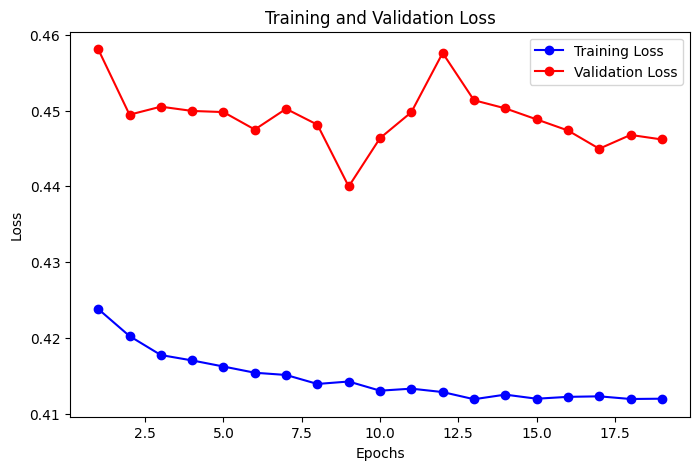

In [123]:
plot_training_history(history)

# Model Evaluation

In [124]:
model.load_weights('/content/drive/My Drive/ERA5 Data/data/training data 2001/earthformer_T1_2001_C2.h5')

In [125]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [126]:
tf_train_dataset = tf.data.Dataset.load("/content/drive/My Drive/ERA5 Data/data/training data 2002")
test_X = tf.stack([ex[0] for ex in tf_train_dataset])
test_y = tf.stack([ex[1] for ex in tf_train_dataset])

In [127]:
test_X_np = test_X.numpy()
test_y_np = test_y.numpy()

In [128]:
print(np.isnan(test_X).sum(), np.isinf(test_X).sum())

0 0


In [129]:
print(np.isnan(test_y).sum(), np.isinf(test_y).sum())

0 0


In [130]:
test_X_masked = np.where(test_X_np <= -9999, np.nan, test_X_np)

normalized_test_X_np = (test_X_np - X_channel_mean) / (X_channel_std + 1e-8)
normalized_test_X_np = np.where(test_X_np <= -9999, -9999.0, normalized_test_X_np)
normalized_test_X = tf.convert_to_tensor(normalized_test_X_np, dtype=tf.float32)

print("Normalized test_X shape:", normalized_test_X.shape)
del test_X_np
del test_X_masked
del normalized_test_X_np

Normalized test_X shape: (693, 31, 20, 20, 13)


In [131]:
normalized_test_X = tf.where(tf.equal(normalized_test_X, -9999.0), tf.zeros_like(normalized_test_X), normalized_test_X)

In [132]:
test_y_masked = np.where(test_y_np <= -9999, np.nan, test_y_np)

normalized_test_y_np = (test_y_np - y_channel_mean) / (y_channel_std + 1e-8)
normalized_test_y_np = np.where(test_y_np <= -9999, -9999.0, normalized_test_y_np)
normalized_test_y = tf.convert_to_tensor(normalized_test_y_np, dtype=tf.float32)

print("Normalized test_y shape:", normalized_test_y.shape)
del test_y_np
del test_y_masked
del normalized_test_y_np

Normalized test_y shape: (693, 31, 20, 20, 13)


In [133]:
normalized_test_y = tf.where(tf.equal(normalized_test_y, -9999.0), tf.zeros_like(normalized_test_y), normalized_test_y)

In [134]:
test_loss = model.evaluate(normalized_test_X, normalized_test_y, verbose=2)
print("Test Loss:", test_loss)

22/22 - 44s - 2s/step - loss: 0.3950
Test Loss: 0.3950238823890686


In [135]:
y_pred = model.predict(normalized_test_X)

22/22 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step


In [136]:
y_true = normalized_test_y.numpy()

In [137]:
def compute_all_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    y_true_clean = y_true_flat[y_true_flat > -9999.0]
    y_pred_clean = y_pred_flat[y_true_flat > -9999.0]

    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)

    nse_numerator = np.sum((y_true_clean - y_pred_clean) ** 2)
    nse_denominator = np.sum((y_true_clean - np.mean(y_true_clean)) ** 2)
    nse = 1 - (nse_numerator / nse_denominator)

    if len(y_true_clean) > 1:
        true_diff = np.diff(y_true_clean)
        pred_diff = np.diff(y_pred_clean)
        trend_agreement = np.sign(true_diff) == np.sign(pred_diff)
        trend_accuracy = np.mean(trend_agreement)
    else:
        trend_accuracy = np.nan

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "NSE": nse,
        "Trend Accuracy (%)": trend_accuracy * 100
    }


In [138]:
def print_metrics(metrics_dict, title="Test Set Metrics"):
    print(f"\n{title}:")
    print("-" * (len(title) + 1))
    for k, v in metrics_dict.items():
        if isinstance(v, (np.float32, np.float64, float)):
            print(f"{k:20}: {v:.4f}")
        else:
            print(f"{k:20}: {v}")

In [139]:
metrics = compute_all_metrics(y_true, y_pred)
print_metrics(metrics)


Test Set Metrics:
-----------------
MAE                 : 0.4282
RMSE                : 0.6285
R2                  : 0.5610
NSE                 : 0.5610
Trend Accuracy (%)  : 72.5885


In [140]:
y_pred = (y_pred * (y_channel_std + 1e-8)) + y_channel_mean

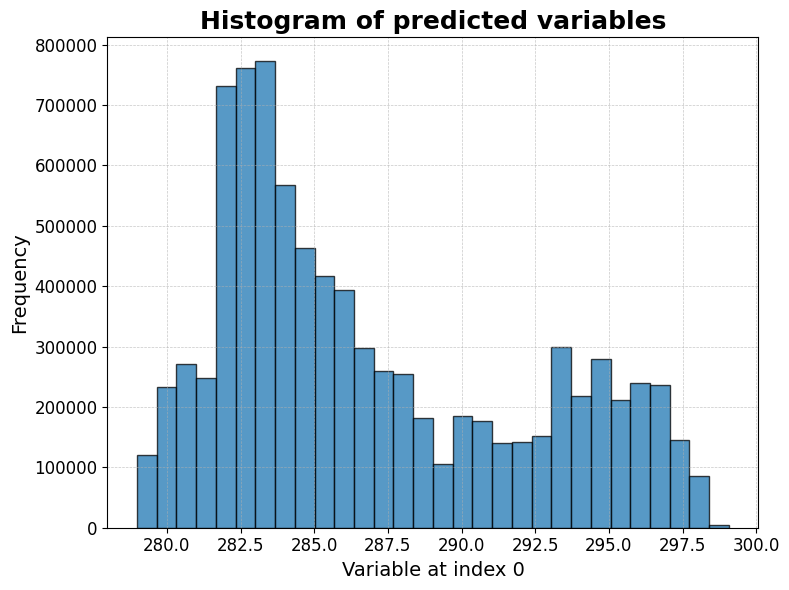

In [141]:
plot_histogram(y_pred[:, :, :, :, 0].flatten(), 'Variable at index 0', 'Histogram of predicted variables')

In [142]:
np.save('/content/drive/My Drive/ERA5 Data/data/training data 2002/pred_X.npy', y_pred)